In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [3]:
df = pd.read_csv("~/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all.csv")

In [4]:
df.shape

(1492, 25)

In [5]:
print('THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED')
print('There are: ')
print(df['PRIMARY_KEY'].duplicated(keep=False).sum(), 'duplicated PRIMARY_KEY s')
print('Unique duplicated keys: \n', df[df['PRIMARY_KEY'].duplicated(keep=False)]['PRIMARY_KEY'].unique())
df[df['PRIMARY_KEY'].duplicated(keep=False)]

THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED
There are: 
9 duplicated PRIMARY_KEY s
Unique duplicated keys: 
 ['2008_DISTRICT_OF_COLUMBIA' '2008_VIRGINIA' '2009_DISTRICT_OF_COLUMBIA'
 '2010_DISTRICT_OF_COLUMBIA']


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
824,2008_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2008,58191.0,1224312.0,85568.0,0.0,1138744.0,1224785.0,520090.0,...,3292.0,2936.0,2092.0,26249.0,10315.0,36676.0,NaN,NaN,NaN,NaN
825,2008_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2008,58191.0,1224312.0,85568.0,0.0,1138744.0,1224785.0,520090.0,...,4595.0,4540.0,3444.0,38190.0,17891.0,63532.0,NaN,NaN,NaN,NaN
863,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,4666.0,3863.0,2535.0,36807.0,12837.0,51345.0,NaN,NaN,NaN,NaN
864,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,2548.0,1485.0,484.0,19226.0,2758.0,24554.0,NaN,NaN,NaN,NaN
865,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,91133.0,92881.0,87177.0,735090.0,380787.0,1145864.0,NaN,NaN,NaN,NaN
878,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2009,44331.0,801008.0,75856.0,0.0,725152.0,805362.0,330698.0,...,4893.0,4452.0,3301.0,37698.0,17597.0,63794.0,219.260141,253.595187,201.984638,252.631381
879,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2009,44331.0,801008.0,75856.0,0.0,725152.0,805362.0,330698.0,...,3423.0,2860.0,2188.0,26762.0,9970.0,36823.0,219.260141,253.595187,201.984638,252.631381
930,2010_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2010,43866.0,1195934.0,80585.0,0.0,1115349.0,1290048.0,526469.0,...,3397.0,2992.0,2203.0,27264.0,9977.0,NaN,NaN,NaN,NaN,NaN
931,2010_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2010,43866.0,1195934.0,80585.0,0.0,1115349.0,1290048.0,526469.0,...,4877.0,4307.0,3407.0,37867.0,17632.0,65080.0,NaN,NaN,NaN,NaN


In [6]:
df['avg_total_revenue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']

df['fracn_schoolage'] = df['GRADES_ALL_G']/df['ENROLL']
df['rev_per_person'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['exp_per_rev'] = df['TOTAL_EXPENDITURE'] / df['TOTAL_REVENUE']


In [7]:
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']
print('2 rows have unreasonably high avg_total_expenditure')
df[df['avg_total_expenditure'] > 100]

2 rows have unreasonably high avg_total_expenditure


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,fracn_schoolage,rev_per_person,exp_per_rev,avg_total_expenditure
863,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,51345.0,NaN,NaN,NaN,NaN,287.625280,0.041715,11.998242,1.031702,296.743714
864,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,24554.0,NaN,NaN,NaN,NaN,601.454753,0.019949,11.998242,1.031702,620.522359


2 rows have unreasonably high avg_total_expenditure


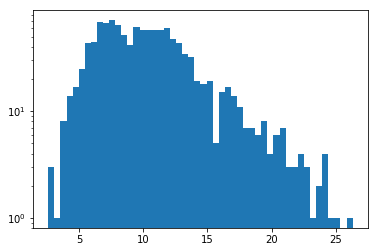

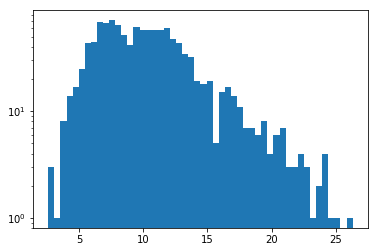

THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED
There are: 
0 duplicated PRIMARY_KEY s
Unique duplicated keys: 
 []


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,avg_total_expenditure,fracn_schoolage,rev_per_person,exp_per_rev


In [53]:
plt.hist('avg_total_expenditure', bins=50, log=True, data=df);
plt.show()
# df[df['avg_total_expenditure'] > 100]

# Drop the 2 outlier rows
df_clean = df[df['avg_total_expenditure'] < 100]

plt.hist('avg_total_expenditure', bins=50, log=True, data=df);
plt.show()

print('THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED')
print('There are: ')
print(df['PRIMARY_KEY'].duplicated(keep=False).sum(), 'duplicated PRIMARY_KEY s')
print('Unique duplicated keys: \n', df[df['PRIMARY_KEY'].duplicated(keep=False)]['PRIMARY_KEY'].unique())
df[df['PRIMARY_KEY'].duplicated(keep=False)]

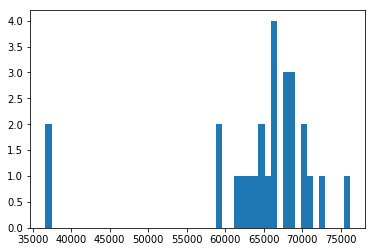

2 rows in DISTRICT_OF_COLUMBIAs data have unreasonably small GRADES_ALL_G


In [9]:
hist_df = df[df['STATE']=='DISTRICT_OF_COLUMBIA']
plt.hist('GRADES_ALL_G', data=hist_df, log=False, bins=50);
plt.show()

print('2 rows in DISTRICT_OF_COLUMBIAs data have unreasonably small GRADES_ALL_G')

In [10]:
print('These DISTRICT_OF_COLUMBIA duplicated keys have unreasonably small GRADES_ALL_G')
print(df[ (df['STATE'] == 'DISTRICT_OF_COLUMBIA') & (df['GRADES_ALL_G'] <  40000)]['GRADES_ALL_G'])
df[ (df['STATE'] == 'DISTRICT_OF_COLUMBIA') & (df['GRADES_ALL_G'] <  40000)]

These DISTRICT_OF_COLUMBIA duplicated keys have unreasonably small GRADES_ALL_G
824    36676.0
879    36823.0
Name: GRADES_ALL_G, dtype: float64


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,avg_total_expenditure,fracn_schoolage,rev_per_person,exp_per_rev
824,2008_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2008,58191.0,1224312.0,85568.0,0.0,1138744.0,1224785.0,520090.0,...,36676.0,NaN,NaN,NaN,NaN,33.381830,33.394727,0.630269,21.039542,1.000386
879,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2009,44331.0,801008.0,75856.0,0.0,725152.0,805362.0,330698.0,...,36823.0,219.260141,253.595187,201.984638,252.631381,21.752926,21.871167,0.830638,18.068801,1.005436


In [11]:
print('Drop these bad rows.')
print('Before drop df.shape=', df.shape)

drop_index= df[(df['STATE'] == 'DISTRICT_OF_COLUMBIA') & (df['GRADES_ALL_G'] <  40000)].index.to_list()
print(drop_index)

df.drop(axis=0, labels= drop_index, inplace=True)
print('After drop df.shape=', df.shape)

Drop these bad rows.
Before drop df.shape= (1216, 30)
[824, 879]
After drop df.shape= (1214, 30)


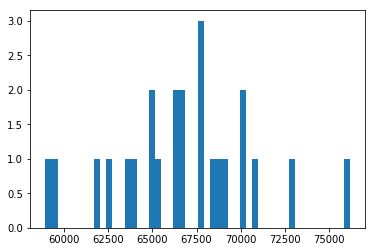

REMOVED: 2 rows in DISTRICT_OF_COLUMBIAs data HAD unreasonably small GRADES_ALL_G


In [12]:
hist_df = df[df['STATE']=='DISTRICT_OF_COLUMBIA']
plt.hist('GRADES_ALL_G', data=hist_df, log=False, bins=50);
plt.show()

print('REMOVED: 2 rows in DISTRICT_OF_COLUMBIAs data HAD unreasonably small GRADES_ALL_G')

In [13]:
print('THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED')
print('There are: ')
print(df['PRIMARY_KEY'].duplicated(keep=False).sum(), 'duplicated PRIMARY_KEY s')
print('Unique duplicated keys: \n', df[df['PRIMARY_KEY'].duplicated(keep=False)]['PRIMARY_KEY'].unique())
df[df['PRIMARY_KEY'].duplicated(keep=False)]

THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED
There are: 
0 duplicated PRIMARY_KEY s
Unique duplicated keys: 
 []


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,avg_total_expenditure,fracn_schoolage,rev_per_person,exp_per_rev


In [14]:
#For some reason VIRGINIA has 3 entries for 2008 and 2 of them have incredibly high avg_instruction_expenditure
df[df['avg_total_expenditure'] > 100]

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,avg_total_expenditure,fracn_schoolage,rev_per_person,exp_per_rev


In [15]:
df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,avg_total_expenditure,fracn_schoolage,rev_per_person,exp_per_rev
count,1214.000000,1.164000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.164000e+03,...,1.214000e+03,479.000000,475.000000,476.000000,443.000000,1214.000000,1214.000000,1164.000000,1164.000000,1214.000000
mean,2003.530478,9.166842e+05,8.922752e+06,7.547590e+05,4.133878e+06,4.034115e+06,9.036754e+06,4.675527e+06,2.630462e+06,4.227990e+05,...,8.602173e+05,234.384303,278.110556,218.662978,263.485789,10.372979,10.421263,0.947725,10.016423,1.007401
std,6.906654,1.054153e+06,1.131445e+07,1.121221e+06,5.300473e+06,5.310380e+06,1.158441e+07,6.075892e+06,3.234789e+06,5.168056e+05,...,9.891287e+05,10.522297,10.367962,7.922590,6.840882,4.011296,3.974681,0.076139,3.989669,0.043447
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,...,5.892700e+04,187.134670,232.831510,178.557612,236.379102,2.576621,2.563009,0.800923,3.543637,0.717038
25%,1998.000000,2.673202e+05,2.189045e+06,1.902835e+05,1.165477e+06,7.148415e+05,2.172325e+06,1.172759e+06,6.376580e+05,1.034492e+05,...,2.573745e+05,228.719632,271.905356,214.399954,259.312874,7.358710,7.389888,0.923023,7.133709,0.984657
50%,2004.000000,6.531095e+05,5.063910e+06,4.002160e+05,2.502170e+06,2.036751e+06,5.185218e+06,2.641565e+06,1.521478e+06,2.710355e+05,...,6.104760e+05,236.819778,280.453026,220.245515,264.886342,9.840336,9.884785,0.935386,9.289085,1.007017
75%,2009.750000,1.014540e+06,1.066705e+07,8.184432e+05,4.863387e+06,4.703754e+06,1.060568e+07,5.532012e+06,3.143274e+06,5.135950e+05,...,9.677510e+05,242.030188,285.061652,223.896863,268.134383,12.437640,12.438096,0.950958,11.717453,1.030618
max,2015.000000,6.307022e+06,7.462693e+07,9.990221e+06,4.318764e+07,3.494151e+07,7.661886e+07,4.195426e+07,2.231086e+07,3.759373e+06,...,5.944746e+06,253.420961,300.568235,236.773867,277.191363,25.775146,26.334393,1.782240,29.948695,1.185742


In [16]:
#sns.pairplot(df, kind='scatter')

(28, 28)


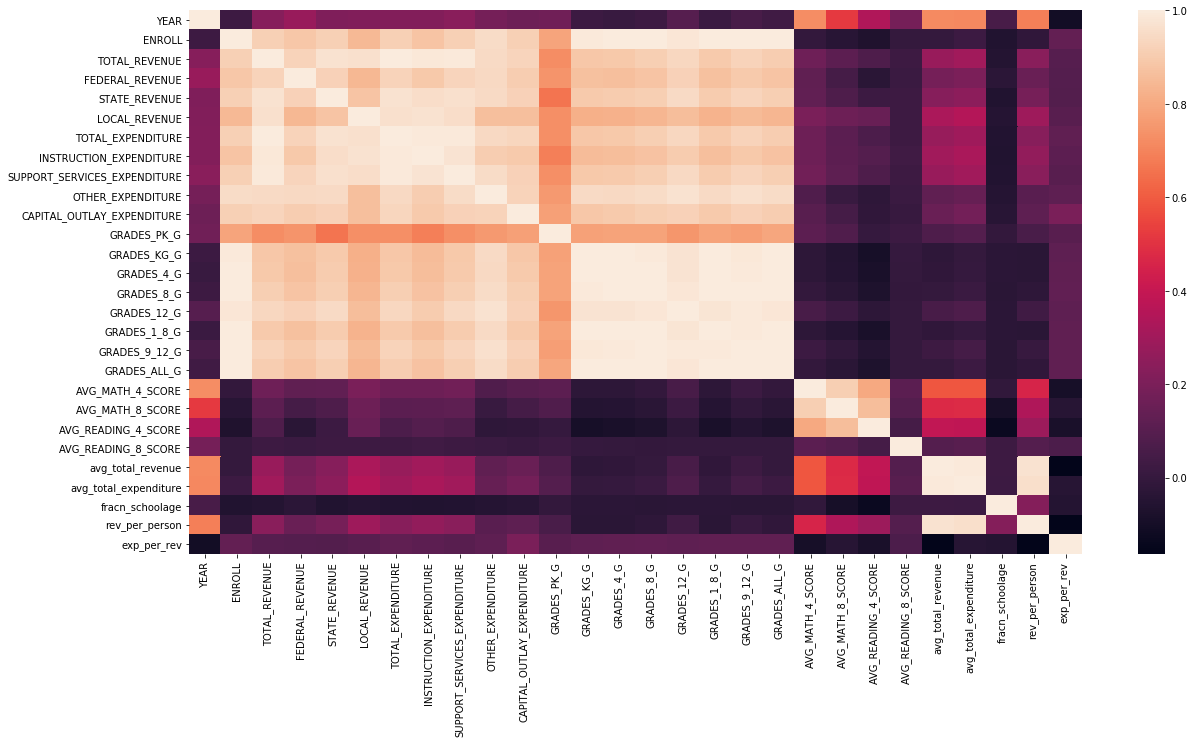

In [17]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr)

In [18]:
# KMeans Clustering

from sklearn.cluster import KMeans
# df.drop(['AVG_MATH_4_SCORE'], axis=1)
print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)

kmeans = KMeans(n_clusters=10)
y_pred = kmeans.fit_predict(df1)

(1214, 30)
(412, 30)


In [19]:
print(df1.columns)

Index(['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE',
       'AVG_READING_8_SCORE', 'avg_total_revenue', 'avg_total_expenditure',
       'fracn_schoolage', 'rev_per_person', 'exp_per_rev', 'STATE_ALABAMA',
       'STATE_ALASKA', 'STATE_ARIZONA', 'STATE_ARKANSAS', 'STATE_CALIFORNIA',
       'STATE_COLORADO', 'STATE_CONNECTICUT', 'STATE_DELAWARE',
       'STATE_DISTRICT_OF_COLUMBIA', 'STATE_FLORIDA', 'STATE_GEORGIA',
       'STATE_HAWAII', 'STATE_IDAHO', 'STATE_ILLINOIS', 'STATE_INDIANA',
       'STATE_IOWA', 'STATE_KANSAS', 'STATE_KENTUCKY', 'STATE_LOUISIANA',
       'STATE_MAINE', 'STATE_MARYLAND', 'STATE_MASSACHUSETTS',
       'STATE_MICHIGAN', 'STATE_MINNESOTA', 'STATE_MISSISSIPPI',
       'STATE_MISSOURI', 'STATE_MONTANA', 'STATE_NEBRASKA', 'STATE_NEVADA',
       'STATE_NEW_HAMPSHIRE', 'STATE_NEW_JERSEY', 'STATE_NEW_MEXICO',
       'STATE_NEW_YORK', 'STATE_NORTH_CAROLINA', 'STATE_NORTH_DAKOTA',
       'STATE_OHIO', 'STATE_OKLAHOMA', 'STATE_OREGON', 'STATE_PENNSYLVANI

In [20]:
kmeans.cluster_centers_
centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=df1.columns)
centers.sort_values('AVG_MATH_4_SCORE')

,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,avg_total_expenditure,fracn_schoolage,rev_per_person,exp_per_rev,STATE_ALABAMA,...,STATE_SOUTH_DAKOTA,STATE_TENNESSEE,STATE_TEXAS,STATE_UTAH,STATE_VERMONT,STATE_VIRGINIA,STATE_WASHINGTON,STATE_WEST_VIRGINIA,STATE_WISCONSIN,STATE_WYOMING
5,202.033098,240.746894,189.678570,257.319746,15.053500,14.929112,0.985520,15.087626,0.994911,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,217.578207,261.922761,206.800785,264.697020,7.107711,7.173528,0.948767,6.860037,1.011315,1.666667e-01,...,3.469447e-18,8.333333e-02,6.938894e-18,3.469447e-18,3.469447e-18,6.938894e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18
0,228.205212,270.027817,214.014786,256.315362,9.018478,9.031495,0.931291,8.393036,1.005496,3.030303e-02,...,3.469447e-18,3.030303e-02,3.030303e-02,3.469447e-18,3.469447e-18,3.030303e-02,3.030303e-02,1.212121e-01,3.469447e-18,3.469447e-18
9,231.094410,270.805416,211.511830,267.731823,11.428494,11.373715,0.982436,11.489652,1.001325,8.333333e-02,...,3.469447e-18,6.250000e-02,0.000000e+00,3.469447e-18,3.469447e-18,0.000000e+00,3.469447e-18,8.333333e-02,3.469447e-18,3.469447e-18
7,235.487699,280.365928,221.156416,249.786858,10.360666,10.360006,0.936476,9.709928,1.000190,6.938894e-18,...,3.469447e-18,6.938894e-18,6.938894e-18,3.469447e-18,3.469447e-18,6.938894e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18
8,236.382443,279.826299,219.606368,265.637013,9.738595,9.915455,0.948969,9.239055,1.018122,-4.510281e-17,...,1.136364e-02,3.409091e-02,3.409091e-02,6.818182e-02,1.136364e-02,2.272727e-02,1.136364e-02,3.469447e-18,2.272727e-02,-3.122502e-17
6,239.344641,282.234744,220.706119,265.955702,19.068399,19.219318,0.937792,17.876277,1.006905,6.938894e-18,...,3.469447e-18,6.938894e-18,6.938894e-18,3.469447e-18,3.469447e-18,6.938894e-18,3.469447e-18,3.469447e-18,3.469447e-18,7.692308e-02
2,242.782714,286.190575,223.535405,269.004102,12.180922,12.200284,0.942405,11.474192,1.003294,-3.816392e-17,...,6.493506e-02,-3.816392e-17,5.194805e-02,2.597403e-02,3.469447e-18,2.597403e-02,3.896104e-02,3.469447e-18,5.194805e-02,-2.081668e-17
1,243.418526,286.377887,224.100873,258.064482,12.877786,12.852721,0.947322,12.215843,0.999170,-3.469447e-18,...,1.960784e-02,-3.469447e-18,1.960784e-02,3.469447e-18,1.960784e-02,7.843137e-02,5.882353e-02,3.469447e-18,3.921569e-02,3.921569e-02
4,247.433078,291.708392,229.614786,264.938821,18.899916,18.713385,0.948567,17.909230,0.990640,6.938894e-18,...,3.469447e-18,6.938894e-18,6.938894e-18,3.469447e-18,1.818182e-01,6.938894e-18,3.469447e-18,3.469447e-18,3.469447e-18,9.090909e-02


In [21]:
centers['AVG_MATH_4_SCORE']

0    228.205212
1    243.418526
2    242.782714
3    217.578207
4    247.433078
5    202.033098
6    239.344641
7    235.487699
8    236.382443
9    231.094410
Name: AVG_MATH_4_SCORE, dtype: float64

In [22]:
centers.describe()

,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,avg_total_expenditure,fracn_schoolage,rev_per_person,exp_per_rev,STATE_ALABAMA,...,STATE_SOUTH_DAKOTA,STATE_TENNESSEE,STATE_TEXAS,STATE_UTAH,STATE_VERMONT,STATE_VIRGINIA,STATE_WASHINGTON,STATE_WEST_VIRGINIA,STATE_WISCONSIN,STATE_WYOMING
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,...,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01
mean,232.376003,275.020671,216.072594,261.945093,12.573447,12.576902,0.950954,12.025488,1.003137,2.803030e-02,...,9.590654e-03,2.102273e-02,1.359498e-02,9.415584e-03,2.127897e-02,1.574357e-02,1.394512e-02,2.045455e-02,1.138910e-02,2.070479e-02
std,13.703013,14.999577,11.406559,6.196201,4.018869,3.982474,0.018427,3.827630,0.007908,5.556129e-02,...,2.057603e-02,3.075279e-02,1.919287e-02,2.220330e-02,5.680719e-02,2.534722e-02,2.129400e-02,4.403652e-02,1.959559e-02,3.564113e-02
min,202.033098,240.746894,189.678570,249.786858,7.107711,7.173528,0.931291,6.860037,0.990640,-4.510281e-17,...,0.000000e+00,-3.816392e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.122502e-17
25%,228.927512,270.222217,212.137569,257.505930,9.894112,10.026593,0.938945,9.356773,0.999425,-2.602085e-18,...,3.469447e-18,1.734723e-18,6.938894e-18,3.469447e-18,3.469447e-18,6.938894e-18,3.469447e-18,3.469447e-18,3.469447e-18,8.673617e-19
50%,235.935071,280.096113,220.156243,264.817921,11.804708,11.787000,0.947944,11.481922,1.002310,6.938894e-18,...,3.469447e-18,6.938894e-18,6.938894e-18,3.469447e-18,3.469447e-18,6.938894e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18
75%,241.923196,285.201617,222.940658,265.876030,14.509572,14.410014,0.948918,14.369680,1.006552,2.272727e-02,...,8.522727e-03,3.314394e-02,2.762923e-02,3.469447e-18,8.522727e-03,2.516234e-02,2.556818e-02,3.469447e-18,1.704545e-02,2.941176e-02
max,247.433078,291.708392,229.614786,269.004102,19.068399,19.219318,0.985520,17.909230,1.018122,1.666667e-01,...,6.493506e-02,8.333333e-02,5.194805e-02,6.818182e-02,1.818182e-01,7.843137e-02,5.882353e-02,1.212121e-01,5.194805e-02,9.090909e-02


In [23]:
print(y_pred)

[3 3 3 3 8 8 5 3 3 8 0 3 7 0 7 8 3 0 3 0 0 0 8 3 3 3 3 8 5 0 3 7 8 7 9 3 7
 0 2 8 8 8 7 3 3 7 8 8 9 7 0 3 8 8 8 8 0 3 9 9 9 0 8 2 7 5 0 0 0 8 8 8 7 2
 0 0 7 8 2 8 2 3 8 7 8 0 2 6 3 7 8 2 8 0 8 8 0 8 8 9 8 8 1 8 8 0 8 1 3 9 9
 0 9 8 1 1 5 8 0 9 8 8 7 2 1 0 0 2 8 4 8 2 3 7 2 8 9 1 6 0 6 8 2 1 9 8 7 9
 8 2 9 8 8 4 1 1 9 1 1 9 6 0 8 9 1 1 1 5 7 8 9 8 7 2 1 1 7 9 1 2 4 8 1 0 8
 2 2 0 2 4 9 6 8 1 2 8 7 1 8 8 2 0 2 8 4 1 2 0 1 4 9 6 9 8 0 1 4 1 3 2 8 9
 7 2 2 1 1 8 9 2 4 4 8 1 9 2 2 1 9 1 4 9 6 1 2 2 7 8 1 6 8 1 8 2 8 4 2 1 0
 2 6 0 6 8 8 9 1 4 1 9 2 8 7 2 6 1 1 2 2 9 2 4 4 7 2 9 2 2 2 7 4 4 9 6 2 2
 1 8 8 4 6 8 2 9 2 8 4 1 1 9 2 6 9 6 8 8 9 1 4 2 9 2 7 2 8 6 1 2 2 2 9 2 4
 4 8 4 9 2 2 1 8 4 4 9 6 2 1 2 8 2 4 6 8 2 8 1 2 4 1 2 9 2 4 9 6 8 8 1 6 6
 9 7 8 6 8 6 2 2 2 2 9 2 1 4 8 2 9 2 1 2 9 4 4 9 6 1 4 1 8 6 6 8 2 8 2 2 4
 2 2 9 2 4]


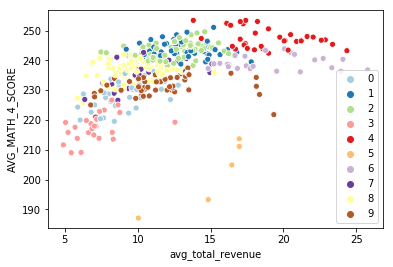

In [24]:
sns.scatterplot('avg_total_revenue', 'AVG_MATH_4_SCORE' , hue=y_pred.astype(np.int), data=df1, \
                legend='full', palette="Paired")

In [25]:
# Affinity Propagation Clustering

from sklearn.cluster import AffinityPropagation
# df.drop(['AVG_MATH_4_SCORE'], axis=1)
print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)

aff_prop = AffinityPropagation()
y_aff_prop = aff_prop.fit_predict(df1)

(1214, 30)
(412, 30)


In [26]:
aff_prop.cluster_centers_
centers = pd.DataFrame(data=aff_prop.cluster_centers_, columns=df1.columns)
# centers.sort_values('AVG_MATH_4_SCORE')

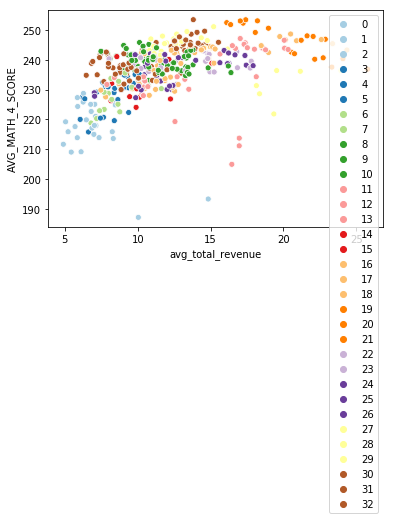

In [27]:
sns.scatterplot('avg_total_revenue', 'AVG_MATH_4_SCORE' , hue=y_aff_prop.astype(np.int), data=df1, \
                legend='full', palette="Paired")

In [28]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
pca.fit(df1)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
(1214, 30)
(412, 30)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Explained Variance')

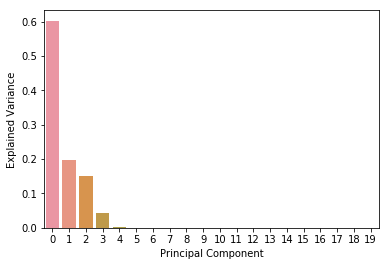

In [29]:
ax = sns.barplot(x=np.arange(20), y=pca.explained_variance_[0:20]/sum(pca.explained_variance_[0:20]))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')

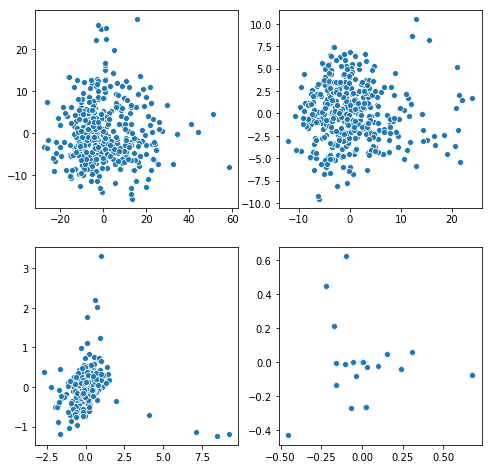

In [30]:
X_pca = pca.fit(df1).transform(df1)
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.scatterplot(X_pca[:,0], X_pca[:,1])
plt.subplot(2,2,2)
sns.scatterplot(X_pca[:,2], X_pca[:,3])
plt.subplot(2,2,3)
sns.scatterplot(X_pca[:,4], X_pca[:,5])
plt.subplot(2,2,4)
sns.scatterplot(X_pca[:,6], X_pca[:,7])

In [31]:
"""g = sns.FacetGrid(df, row="STATE") 
g.map(plt.scatter, 'YEAR', 'AVG_MATH_4_SCORE')"""

'g = sns.FacetGrid(df, row="STATE") \ng.map(plt.scatter, \'YEAR\', \'AVG_MATH_4_SCORE\')'

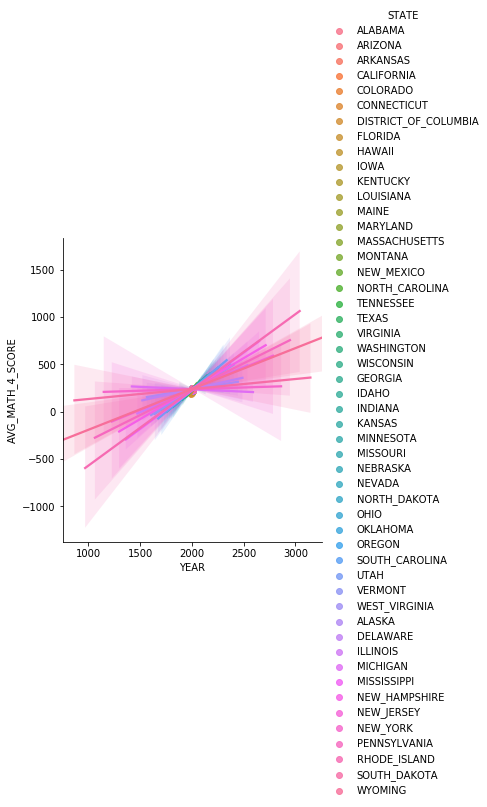

In [32]:
sns.lmplot(x="YEAR", y="AVG_MATH_4_SCORE", hue="STATE", data=df.dropna(), legend_out=True);

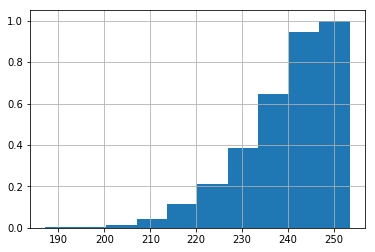

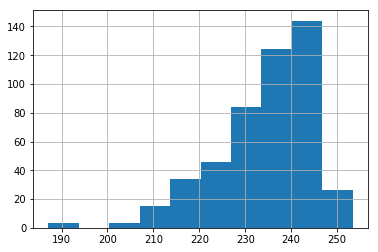

In [33]:
df['AVG_MATH_4_SCORE'].dropna().hist(density=True, cumulative=True)
plt.show()
df['AVG_MATH_4_SCORE'].dropna().hist()

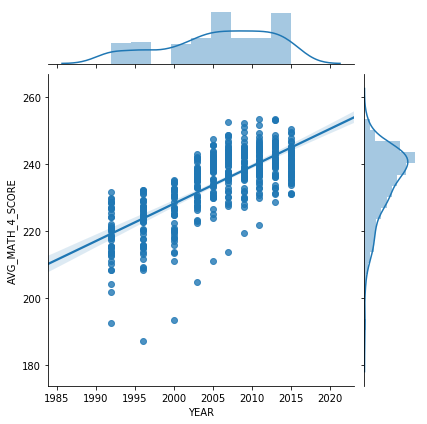

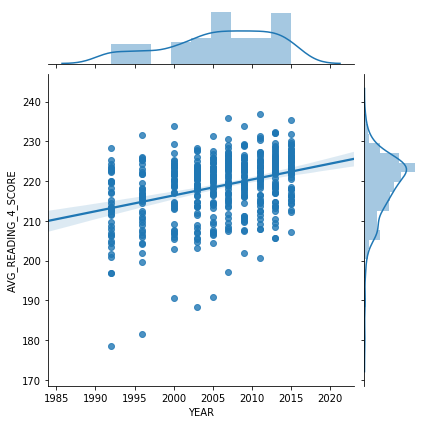

In [34]:
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_READING_4_SCORE", data=df, kind="reg")

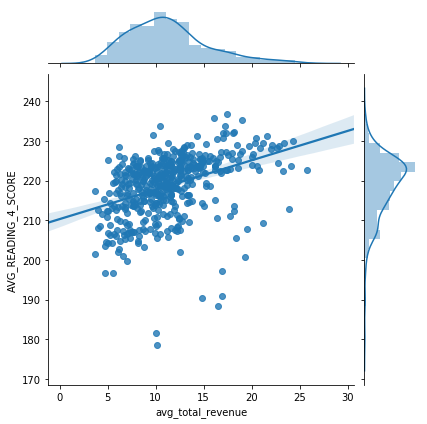

In [35]:
sns.jointplot("avg_total_revenue", "AVG_READING_4_SCORE", data=df, kind="reg")

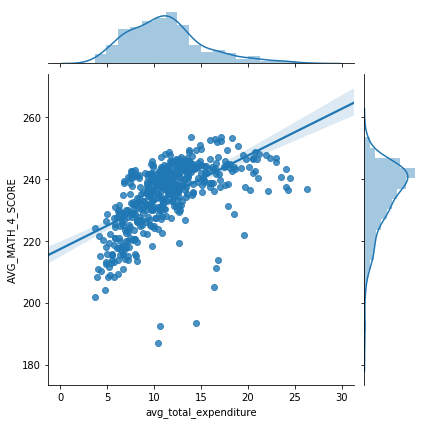

In [36]:
sns.jointplot("avg_total_expenditure", "AVG_MATH_4_SCORE", data=df, kind="reg")

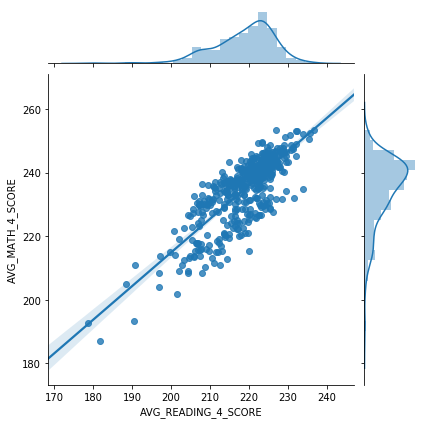

In [37]:
sns.jointplot("AVG_READING_4_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

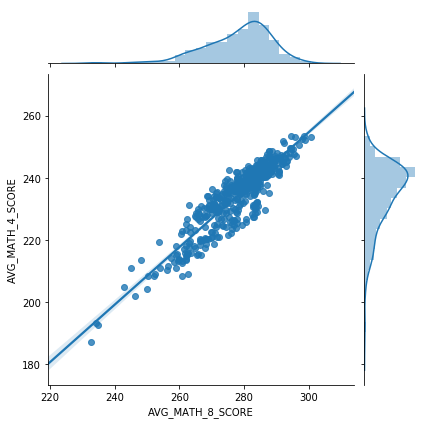

In [38]:
sns.jointplot("AVG_MATH_8_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [39]:
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
print(df1.columns)
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

ts_cv = TimeSeriesSplit(n_splits=5)
print(ts_cv)
for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

"""
PredefinedSplit won't work because it folds in future data

test_fold = df1.loc[:,'YEAR'].values
ps = PredefinedSplit(test_fold)
print(ps.get_n_splits())
for train_index, test_index in ps.split():
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
"""

Index(['STATE', 'YEAR', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE',
       'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE',
       'avg_total_revenue', 'avg_total_expenditure', 'fracn_schoolage',
       'rev_per_person', 'exp_per_rev'],
      dtype='object')
TimeSeriesSplit(max_train_size=None, n_splits=5)


'\nPredefinedSplit won\'t work because it folds in future data\n\ntest_fold = df1.loc[:,\'YEAR\'].values\nps = PredefinedSplit(test_fold)\nprint(ps.get_n_splits())\nfor train_index, test_index in ps.split():\n    print("Train:", train_index, "Test:", test_index)\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]    \n'

In [40]:
n_splits=20
ts_cv = TimeSeriesSplit(n_splits=n_splits)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = np.zeros(n_splits)
test_score = np.zeros(n_splits)

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    Y_rf=rf_model.predict(X_test)
    train_score[index]=rf_model.score(X_train,y_train) #Train score
    test_score[index]=rf_model.score(X_test,y_test) #Test score
    index+=1
index_list=np.arange(index)

In [41]:
print(index)
print(index_list)
print(train_score)
print(test_score)

20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0.85376797 0.90161146 0.91714091 0.93269481 0.93382471 0.93656118
 0.9470897  0.94826888 0.95493353 0.95627594 0.95813052 0.96165078
 0.9652496  0.96526093 0.96708088 0.96614175 0.96738978 0.97107938
 0.97143353 0.97236742]
[ 0.52967573  0.20880278 -0.06747813 -0.70682274 -0.30538005  0.69161711
  0.04252844  0.61260131  0.43090358  0.18053664  0.58371094  0.49087619
  0.63706682  0.74927765  0.43589045  0.53206197  0.74019483  0.4763401
  0.74632961  0.58878622]


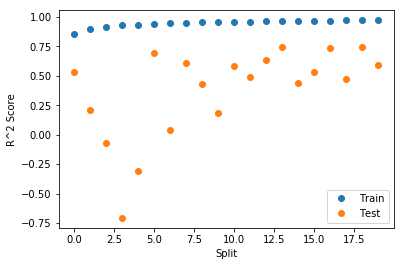

In [42]:
plt.plot(index_list,train_score,'o', label="Train")
plt.plot(index_list,test_score,'o', label="Test")
plt.xlabel("Split")
plt.ylabel("R^2 Score")
plt.legend(loc="best")

In [43]:
model=RandomForestRegressor()

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""
param_search = [
  {'n_estimators': [1, 10, 20, 100]}
]
gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
gsrch_rf_model.fit(X,y)
"""

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[4,5,6,7,8,9,10,20,30,40,50,60]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, cv=ts_cv, n_jobs=-1)

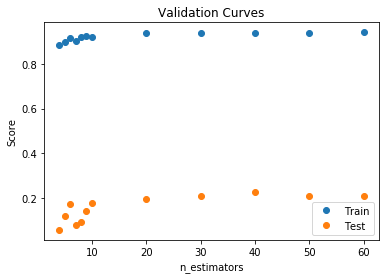

In [44]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [45]:
model=RandomForestRegressor(n_estimators=20)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:1310: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes' 18 instead of 30).
  % (train_sizes_abs.shape[0], n_ticks), RuntimeWarning)


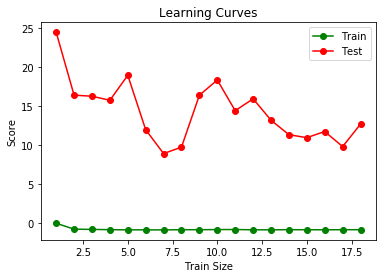

In [46]:
plt.figure()
plt.plot(train_sizes, -train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, -test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [47]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

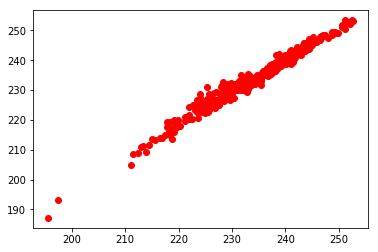

In [48]:
Y_rf=rf_model.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [49]:
rf_model.score(X,y)

0.9730994107383643

In [50]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

,importance
YEAR,0.458270
avg_total_revenue,0.071365
GRADES_ALL_G,0.050831
avg_total_expenditure,0.040802
rev_per_person,0.035550
fracn_schoolage,0.035516
STATE_REVENUE,0.023721
GRADES_12_G,0.023243
LOCAL_REVENUE,0.018296
FEDERAL_REVENUE,0.017026


ValueError: Could not interpret input 'fracn_enroll_GRADES_12_G'

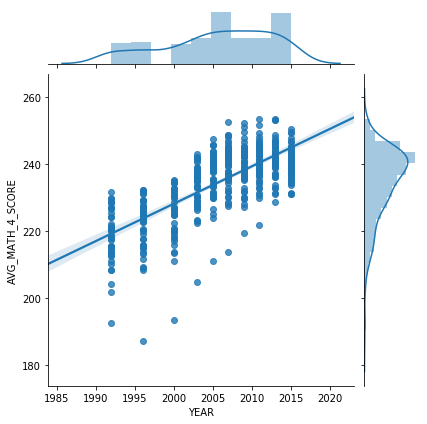

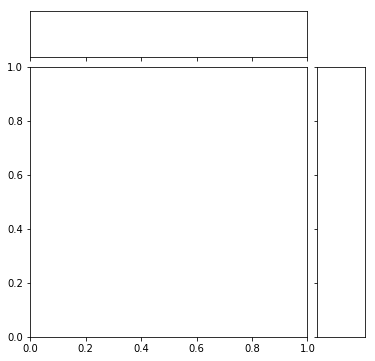

In [51]:
sns.jointplot(x='YEAR', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_enroll_GRADES_12_G', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_rev_FEDERAL_REVENUE', y='AVG_MATH_4_SCORE', data=df, kind='reg')

In [ ]:
from sklearn import svm
svm_model = svm.SVR(gamma='scale')
svm_model.fit(X, y)  

In [ ]:
Y_svm=svm_model.predict(X)
plt.plot(Y_svm, y, 'ro')
plt.show()

# Lasso

In [ ]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [ ]:
lasso_best_alpha = 0.1

In [ ]:
model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
#lasso_model.fit(X, y)  
#Y_lasso=lasso_model.predict(X)

num_splits=5
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

print(train_sizes.shape,train_scores.shape, test_scores.shape)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes,train_scores_mean,'o',label="Train")
plt.plot(train_sizes,test_scores_mean,'o',label="Test")
plt.xlabel("Train Sizes")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [ ]:
"""Plot test data fit"""

In [ ]:

lasso_model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [ ]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_.round(), X_cols))

In [ ]:
# Lasso 
# Validation Curve
# Scaled Features

scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

model=linear_model.Lasso(normalize=True)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]
"""
#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X_transformed, y=y, param_name="alpha", \
    param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [ ]:
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

print('alpha=', lasso_best_alpha)
model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
lasso_model.fit(X_transformed, y)  
Y_lasso=lasso_model.predict(X_transformed)

lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_, X_cols))

In [ ]:
"""fracn_GRADES_12div8_G
is not chosen by Lasso. RandomForest says it's #2 tho. Why?
Plot.
"""
plt.figure(figsize=[7,7])
x1=df1.loc[:,'fracn_GRADES_12div8_G'].values
plt.plot(x1,y,'o')
plt.plot(x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_GRADES_12div8_G")
plt.ylabel("y")

In [ ]:
plt.figure(figsize=[20,10])

plt.subplot(2, 2, 1)
x1=df1.loc[:,'fracn_enroll_GRADES_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 2)
x1=df1.loc[:,'fracn_enroll_GRADES_9_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_9_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 3)
x1=df1.loc[:,'YEAR'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("YEAR")
plt.ylabel("y")

plt.subplot(2, 2, 4)
x1=df1.loc[:,'STATE_DISTRICT_OF_COLUMBIA'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("STATE_DISTRICT_OF_COLUMBIA")
plt.ylabel("y")

In [ ]:
plt.figure(figsize=[15,10])

plt.subplot(2, 2, 1)
plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [ ]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

In [ ]:
"""The largest coefficients are"""
X_cols[np.abs(lasso_coef_)>0.5]
""". Plot them with fits."""

plt.plot(Y_svm, y, 'ro')("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")


In [ ]:
"""
Can I predict test scores for a year?

Handle time better. Time_series_split

Time trends: 
-Scores
-Populations
-Revenues
-Expenditures

Delta from previous time point as feature?

Features:
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...


"""